# Capstone2 - 3 Pre-processing and Training Data Development & Modeling

# 3.1 Imports 

In [1]:
#!pip install xgboost

In [2]:
#!pip install numpy --upgrade

In [3]:
#!pip install --upgrade matplotlib seaborn scikit-learn xgboost

In [127]:
#pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.preprocessing import LabelEncoder
import time
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

# 3.2 Load Data

In [10]:
orders17 = pd.read_csv(r'C:\Users\JIYOON JUNG\Desktop\Springboard\Unit 15 Data Wrangling\Capstone2\Brazilian E-Commerce Public Dataset by Olist\order17')

In [11]:
orders17.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_size,product_order_size,Year,Month,product_sales_amt,order_sales_amt
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,9350.0,maua,SP,housewares,1,1.0,2017,10,29.99,29.99
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,...,31842.0,belo horizonte,MG,pet_shop,1,1.0,2017,11,45.00,45.00
2,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,060cb19345d90064d1015407193c233d,8581055ce74af1daba164fdbd55a40de,...,7112.0,guarulhos,SP,auto,1,1.0,2017,7,147.90,147.90
3,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,...,5455.0,sao paulo,SP,NaN,1,1.0,2017,4,49.90,49.90
4,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,4520766ec412348b8d4caa5e8a18c464,16090f2ca825584b5a147ab24aa30c86,...,12940.0,atibaia,SP,auto,1,1.0,2017,5,59.99,59.99


In [12]:
orders17.shape

(46314, 27)

In [13]:
orders17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46314 entries, 0 to 46313
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       46314 non-null  object 
 1   customer_id                    46314 non-null  object 
 2   order_status                   46314 non-null  object 
 3   order_purchase_timestamp       46314 non-null  object 
 4   order_approved_at              46300 non-null  object 
 5   order_delivered_carrier_date   45681 non-null  object 
 6   order_delivered_customer_date  45140 non-null  object 
 7   order_estimated_delivery_date  46314 non-null  object 
 8   product_id                     46314 non-null  object 
 9   seller_id                      46314 non-null  object 
 10  shipping_limit_date            46314 non-null  object 
 11  price                          46314 non-null  float64
 12  freight_value                  46314 non-null 

# 3.3 Pre-processing

##### Drop the columns that contain missing values

In [14]:
orders17 = orders17.drop(columns = {'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'})

##### Drop any columns that are not required for analysis.

In [15]:
orders17 = orders17.drop(columns = {'shipping_limit_date'})

###### Replace any missing values with the name of a new product category

In [16]:
missing = pd.concat([orders17.isnull().sum(), 100 * orders17.isnull().mean()], axis=1)
missing.columns=['count', '%']
print(missing.sort_values('%',ascending=False))

                               count         %
product_category_name_english    828  1.787796
order_id                           0  0.000000
customer_state                     0  0.000000
product_sales_amt                  0  0.000000
Month                              0  0.000000
Year                               0  0.000000
product_order_size                 0  0.000000
order_size                         0  0.000000
seller_state                       0  0.000000
seller_city                        0  0.000000
seller_zip_code_prefix             0  0.000000
customer_city                      0  0.000000
customer_id                        0  0.000000
customer_zip_code_prefix           0  0.000000
customer_unique_id                 0  0.000000
freight_value                      0  0.000000
price                              0  0.000000
seller_id                          0  0.000000
product_id                         0  0.000000
order_estimated_delivery_date      0  0.000000
order_purchas

In [17]:
orders17['product_category_name_english'] = orders17['product_category_name_english'].fillna('unknown')

In [18]:
orders17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46314 entries, 0 to 46313
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       46314 non-null  object 
 1   customer_id                    46314 non-null  object 
 2   order_status                   46314 non-null  object 
 3   order_purchase_timestamp       46314 non-null  object 
 4   order_estimated_delivery_date  46314 non-null  object 
 5   product_id                     46314 non-null  object 
 6   seller_id                      46314 non-null  object 
 7   price                          46314 non-null  float64
 8   freight_value                  46314 non-null  float64
 9   customer_unique_id             46314 non-null  object 
 10  customer_zip_code_prefix       46314 non-null  int64  
 11  customer_city                  46314 non-null  object 
 12  customer_state                 46314 non-null 

##### Add 'day' columns and drop 'order_purchase_timestamp'

In [19]:
orders17['day'] = orders17['order_purchase_timestamp'].astype(str).str[8:10]

In [20]:
orders17 = orders17.drop(columns = {'order_purchase_timestamp'})

##### Select the columns to include in the analysis.

In [21]:
df = orders17[[
    'Year',
    'Month',
    'day',
    'order_id',
    'order_size',
    'order_sales_amt',
    'customer_id',
    'customer_unique_id',
    'customer_zip_code_prefix',
    'product_category_name_english',
    'product_id',
    'price',
    'product_order_size',
    'product_sales_amt',
    'seller_id',
    'seller_zip_code_prefix'
]]

In [22]:
df.head()

,Year,Month,day,order_id,order_size,order_sales_amt,customer_id,customer_unique_id,customer_zip_code_prefix,product_category_name_english,product_id,price,product_order_size,product_sales_amt,seller_id,seller_zip_code_prefix
0,2017,10,02,e481f51cbdc54678b7cc49136f2d6af7,1,29.99,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,3149,housewares,87285b34884572647811a353c7ac498a,29.99,1.0,29.99,3504c0cb71d7fa48d967e0e4c94d59d9,9350.0
1,2017,11,18,949d5b44dbf5de918fe9c16f97b45f8a,1,45.00,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,59296,pet_shop,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,1.0,45.00,66922902710d126a0e7d26b0e3805106,31842.0
2,2017,7,09,a4591c265e18cb1dcee52889e2d8acc3,1,147.90,503740e9ca751ccdda7ba28e9ab8f608,80bb27c7c16e8f973207a5086ab329e2,86320,auto,060cb19345d90064d1015407193c233d,147.90,1.0,147.90,8581055ce74af1daba164fdbd55a40de,7112.0
3,2017,4,11,136cce7faa42fdb2cefd53fdc79a6098,1,49.90,ed0271e0b7da060a393796590e7b737a,36edbb3fb164b1f16485364b6fb04c73,98900,unknown,a1804276d9941ac0733cfd409f5206eb,49.90,1.0,49.90,dc8798cbf453b7e0f98745e396cc5616,5455.0
4,2017,5,16,6514b8ad8028c9f2cc2374ded245783f,1,59.99,9bdf08b4b3b52b5526ff42d37d47f222,932afa1e708222e5821dac9cd5db4cae,26525,auto,4520766ec412348b8d4caa5e8a18c464,59.99,1.0,59.99,16090f2ca825584b5a147ab24aa30c86,12940.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46314 entries, 0 to 46313
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           46314 non-null  int64  
 1   Month                          46314 non-null  int64  
 2   day                            46314 non-null  object 
 3   order_id                       46314 non-null  object 
 4   order_size                     46314 non-null  int64  
 5   order_sales_amt                46314 non-null  float64
 6   customer_id                    46314 non-null  object 
 7   customer_unique_id             46314 non-null  object 
 8   customer_zip_code_prefix       46314 non-null  int64  
 9   product_category_name_english  46314 non-null  object 
 10  product_id                     46314 non-null  object 
 11  price                          46314 non-null  float64
 12  product_order_size             46314 non-null 

##### Check the outliers

<AxesSubplot:xlabel='product_sales_amt'>

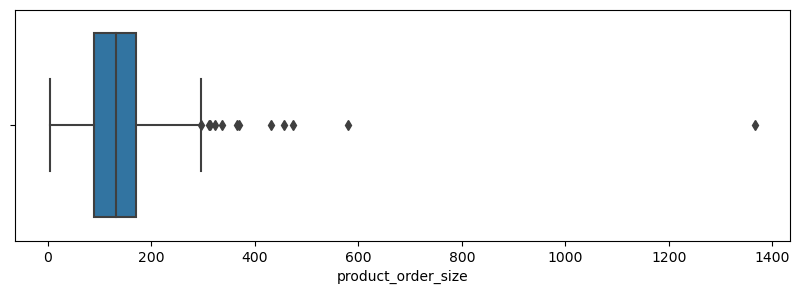

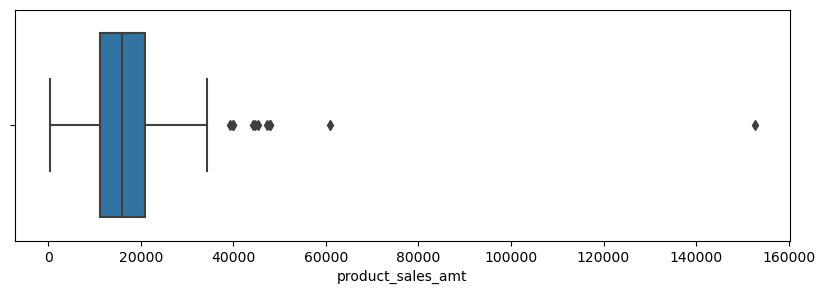

In [24]:
daily_sales = df.groupby(['Month', 'day'])[['product_order_size', 'product_sales_amt']].sum()
daily_sales = daily_sales.reset_index()

plt.figure(figsize=(10,3))
sns.boxplot(x='product_order_size', data=daily_sales)

plt.figure(figsize=(10,3))
sns.boxplot(x='product_sales_amt', data=daily_sales)

In [25]:
# The graph shows a significant increase in sales during the promotion of "Black Friday".
daily_sales[daily_sales['product_order_size']>400]

,Month,day,product_order_size,product_sales_amt
323,11,24,1366.0,152653.74
324,11,25,580.0,60923.48
325,11,26,456.0,45315.28
326,11,27,474.0,47923.66
327,11,28,431.0,47886.55


In [26]:
# The "Black Friday" promotion effect extends from 11/23/2017 to 12/06/2016.
daily_sales[(daily_sales['product_order_size']>300) & (daily_sales['product_order_size']<400)]

,Month,day,product_order_size,product_sales_amt
322,11,23,336.0,44712.88
328,11,29,366.0,39834.75
330,12,01,312.0,39981.91
333,12,04,369.0,47348.52
334,12,05,323.0,33632.37
335,12,06,314.0,39198.74


In [27]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'day']])
daily_sales['Date'] = pd.to_datetime(df[['Year', 'Month', 'day']])

C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_21644\3869159930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df[['Year', 'Month', 'day']])


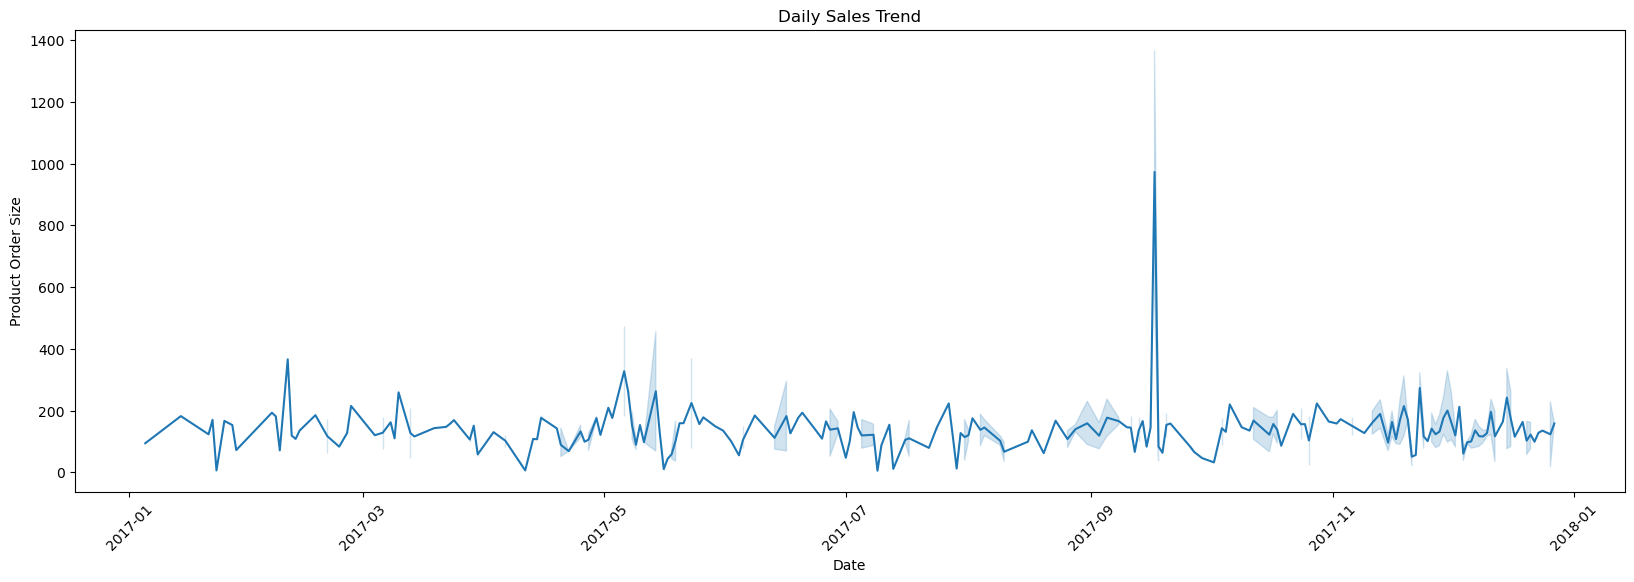

In [28]:
# plot the daily sales trend
plt.figure(figsize=(20,6))
sns.lineplot(x='Date', y='product_order_size', data=daily_sales)

plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Product Order Size')
plt.xticks(rotation=45)
plt.show()

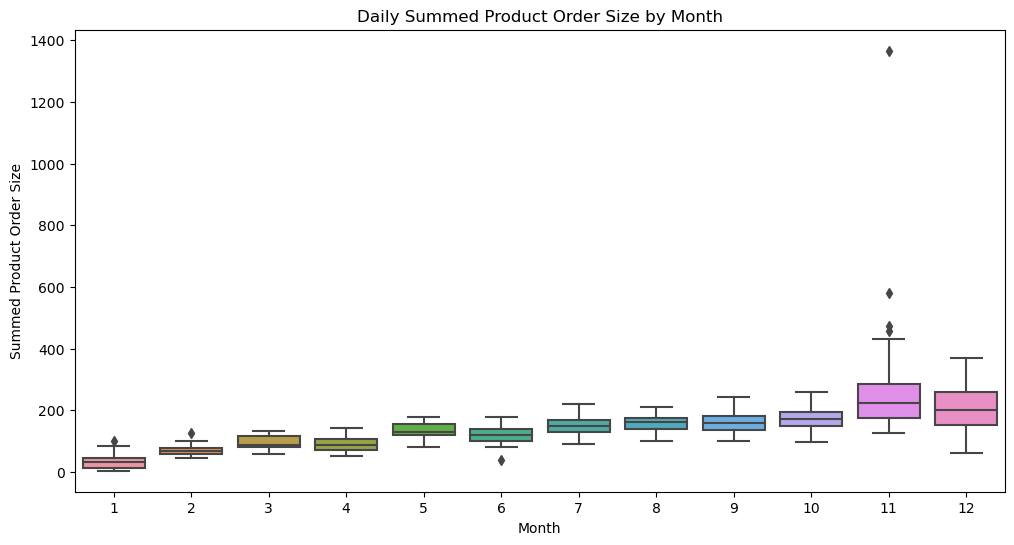

In [29]:
# Box plot for product order size by Month

daily_order = df.groupby(['Month', 'day'])['product_order_size'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='product_order_size', data=daily_order)
plt.title('Daily Summed Product Order Size by Month')
plt.xlabel('Month')
plt.ylabel('Summed Product Order Size')
plt.show()

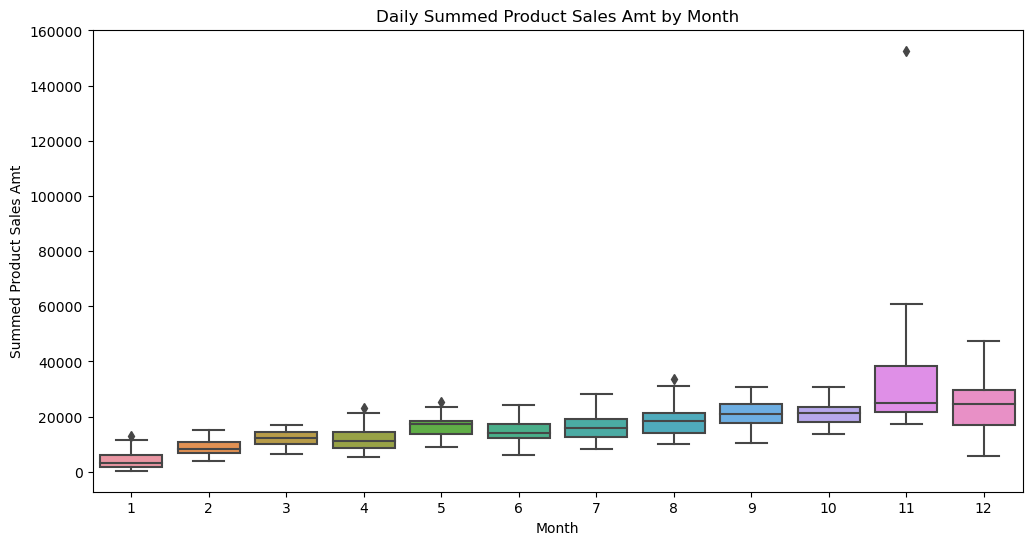

In [30]:
# Box plot for product sales amt by Month

daily_order = df.groupby(['Month', 'day'])['product_sales_amt'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='product_sales_amt', data=daily_order)
plt.title('Daily Summed Product Sales Amt by Month')
plt.xlabel('Month')
plt.ylabel('Summed Product Sales Amt')
plt.show()

##### Check the weekly sales trend

In [31]:
df['week_num'] = df['Date'].dt.isocalendar().week

C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_21644\1093648909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_num'] = df['Date'].dt.isocalendar().week


<AxesSubplot:xlabel='product_sales_amt'>

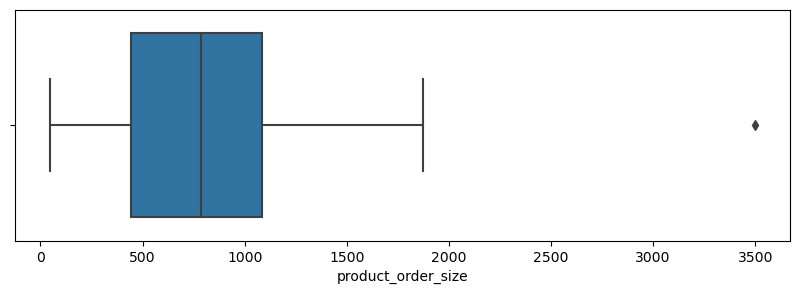

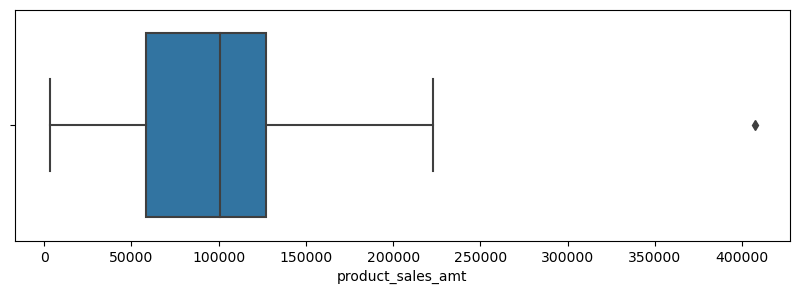

In [32]:
weekly_sales = df.groupby(['Month', 'week_num'])[['product_order_size', 'product_sales_amt']].sum()
weekly_sales = weekly_sales.reset_index()

plt.figure(figsize=(10,3))
sns.boxplot(x='product_order_size', data=weekly_sales)

plt.figure(figsize=(10,3))
sns.boxplot(x='product_sales_amt', data=weekly_sales)

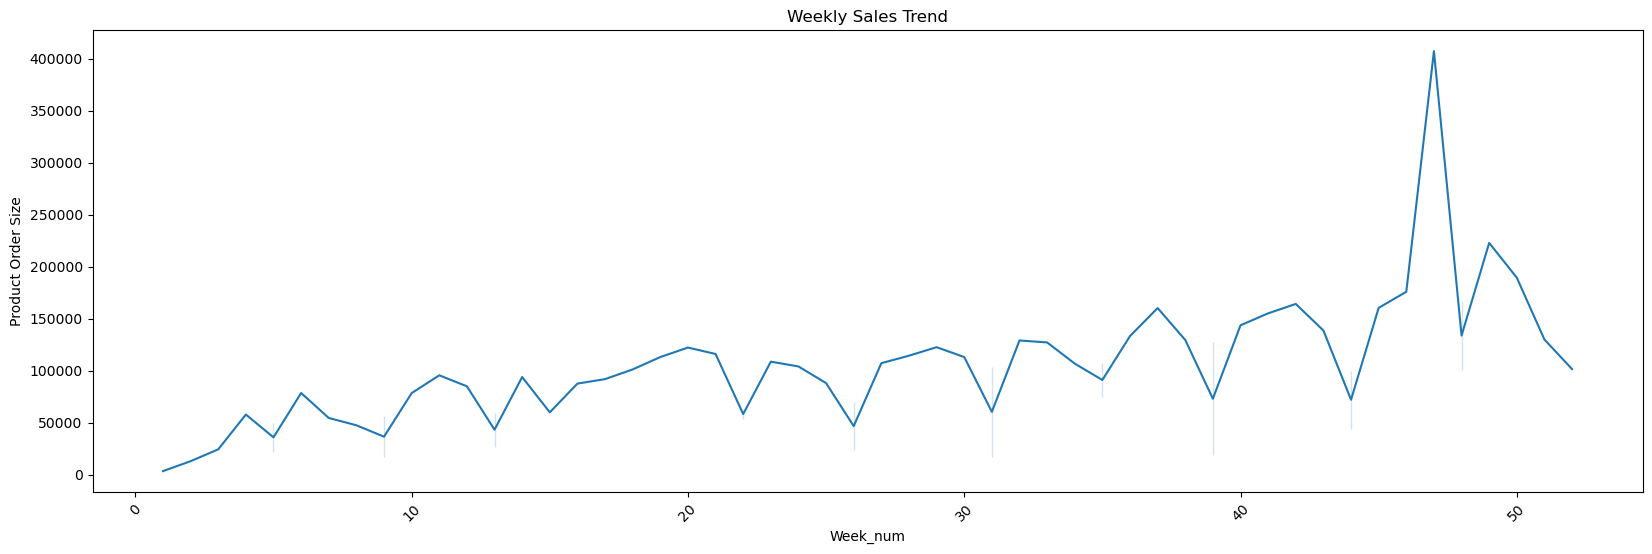

In [33]:
# plot the weekly sales trend
plt.figure(figsize=(20,6))
sns.lineplot(x='week_num', y='product_sales_amt', data=weekly_sales)

plt.title('Weekly Sales Trend')
plt.xlabel('Week_num')
plt.ylabel('Product Order Size')
plt.xticks(rotation=45)
plt.show()

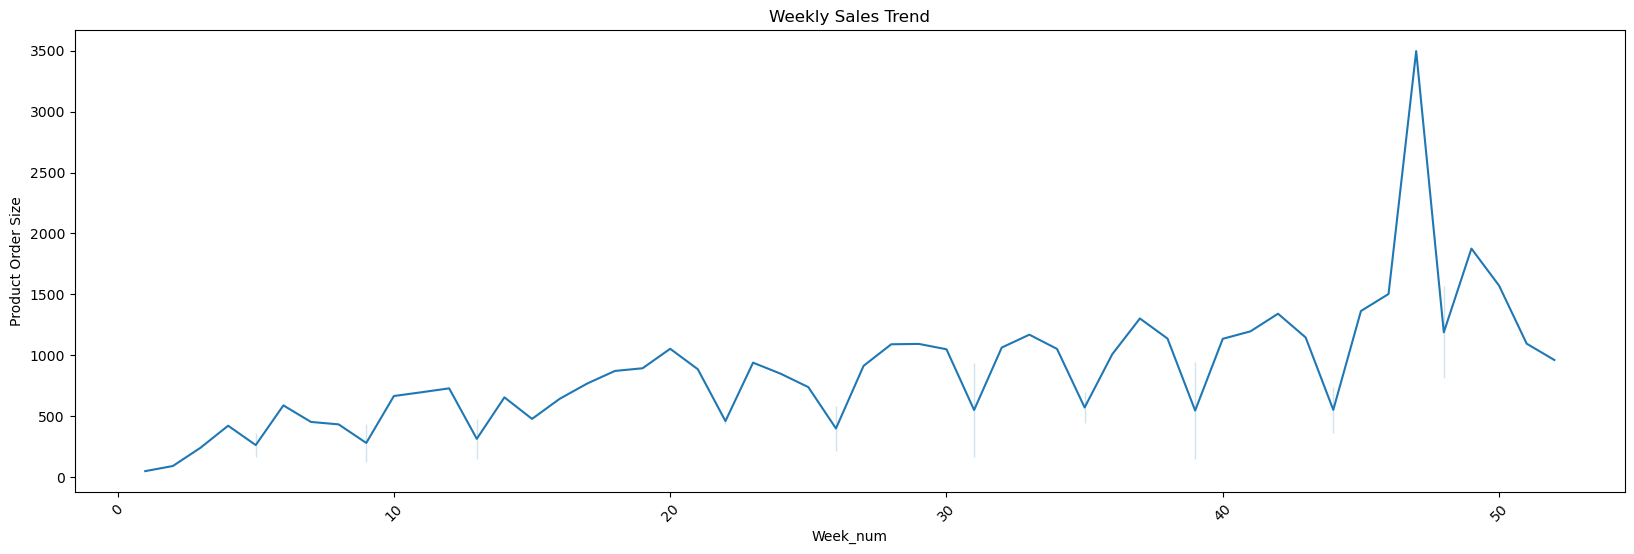

In [34]:
# plot the weekly sales trend
plt.figure(figsize=(20,6))
sns.lineplot(x='week_num', y='product_order_size', data=weekly_sales)

plt.title('Weekly Sales Trend')
plt.xlabel('Week_num')
plt.ylabel('Product Order Size')
plt.xticks(rotation=45)
plt.show()

As we visualize the weekly sales data we can see there is both an upward trend in the data and there is seasonality to it.

In [35]:
# Change the data types of colums

df['day'] = df['day'].astype(int)
df['week_num'] = df['week_num'].astype(int)

df['customer_zip_code_prefix'] = df['customer_zip_code_prefix'].astype(object)
df['seller_zip_code_prefix'] = df['seller_zip_code_prefix'].astype(object)


C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_21644\2083939026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['day'].astype(int)
C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_21644\2083939026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_num'] = df['week_num'].astype(int)
C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_21644\2083939026.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46314 entries, 0 to 46313
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Year                           46314 non-null  int64         
 1   Month                          46314 non-null  int64         
 2   day                            46314 non-null  int32         
 3   order_id                       46314 non-null  object        
 4   order_size                     46314 non-null  int64         
 5   order_sales_amt                46314 non-null  float64       
 6   customer_id                    46314 non-null  object        
 7   customer_unique_id             46314 non-null  object        
 8   customer_zip_code_prefix       46314 non-null  object        
 9   product_category_name_english  46314 non-null  object        
 10  product_id                     46314 non-null  object        
 11  price          

### 3.3.1 Decomposition

#### Trend (Running Average, 4)

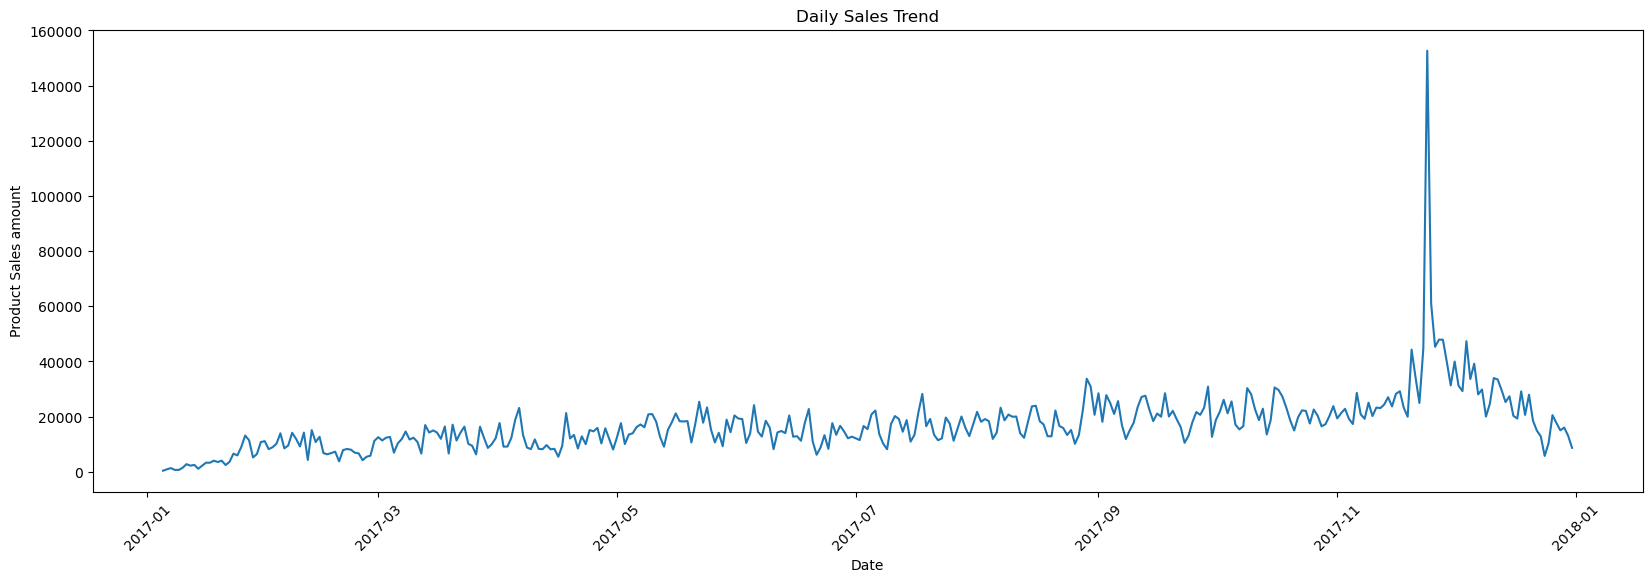

In [38]:
df2 = df.groupby(['Date'])['product_sales_amt'].sum().reset_index()

plt.figure(figsize=(20,6))
sns.lineplot(x='Date', y='product_sales_amt', data=df2)

plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Product Sales amount')
plt.xticks(rotation=45)
plt.show()

In [39]:
df2['product_sales_amt'].autocorr()

0.6555498682497171

Autocorrelation of 0.66 for this time series indicates a positive relationship between consecutive observations, suggesting that the series has a notable trend or pattern that persists over time.

C:\Users\JIYOON JUNG\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


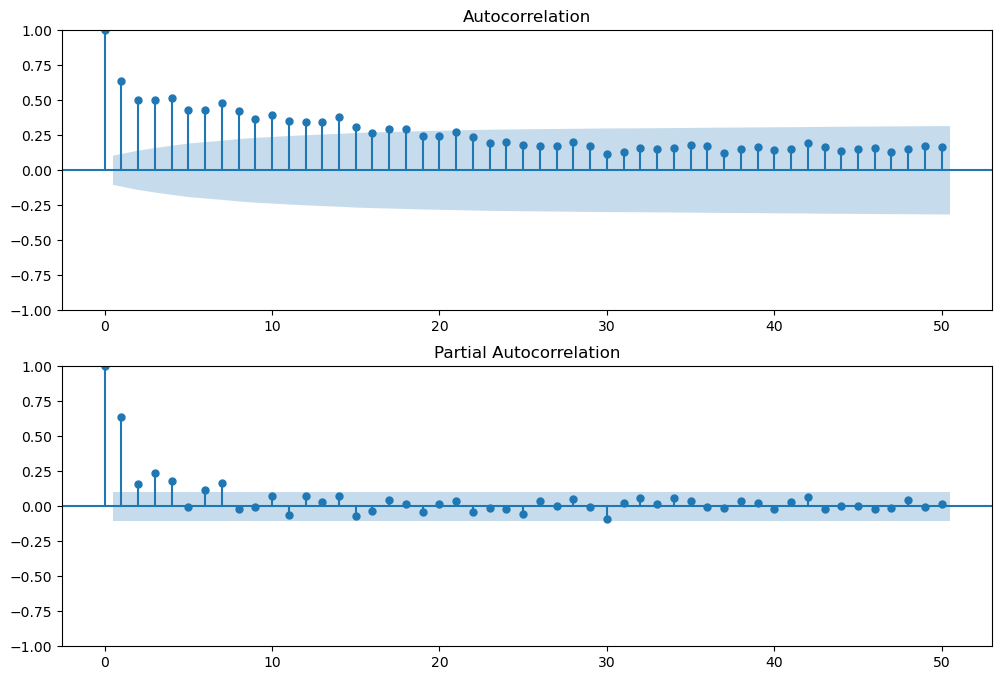

In [41]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df2['product_sales_amt'].iloc[8:], lags=50, ax=ax1, alpha = 0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2['product_sales_amt'].iloc[8:], lags=50, ax=ax2, alpha = 0.05)

In [42]:
def running_average(x, order):
    current = x[:order].sum()
    running = []
    
    for i in range(order, x.shape[0]):
        current += x[i]
        current -= x[i-order]
        running.append(current/order)
    
    return np.array(running)

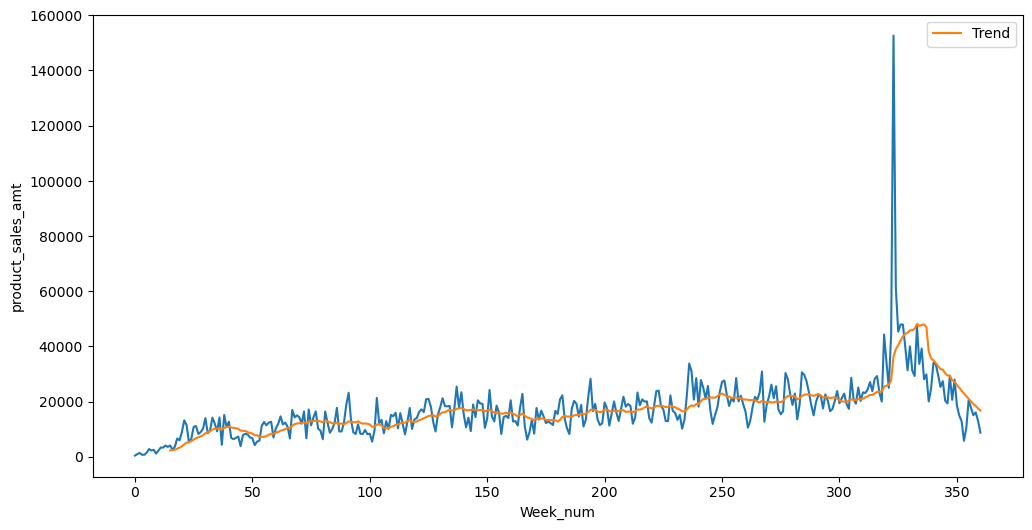

In [50]:
trend = running_average(df2['product_sales_amt'], 15)

fig, ax = plt.subplots(1, 1,  figsize=(12, 6))
ax.plot(df2.index, df2['product_sales_amt'])
ax.set_xlabel('Week_num')
ax.set_ylabel('product_sales_amt')
ax.plot(df2.index[15:], trend8, label='Trend')
ax.legend()

#### Detrending

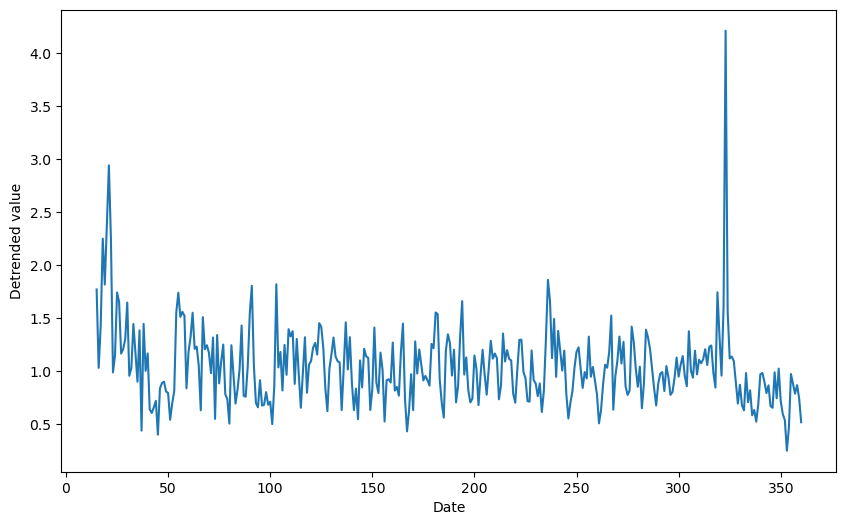

In [52]:
# detrending the data by dividing by the trend
detrended = df2.iloc[15:]['product_sales_amt'].values / trend

fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # Also adding figsize here
ax.plot(df2.index[15:], detrended)
ax.set_xlabel('Date')
ax.set_ylabel('Detrended value')
plt.show()

#### Seasonality

In [53]:
def plot_seasons(detrended, order, plot_mean = True):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    N = len(detrended)

    data = np.array([detrended[i::order] for i in range(order)])
    
    means = np.mean(data, axis=1)
    medians = np.median(data, axis=1)
    
    counts = [0]
    counts.extend([len(data[i]) for i in range(order)])
    counts = np.cumsum(counts)

    ticks = (counts[:-1]+counts[1]/2)
    
    for i in range(order):
        values = data[i, :]
        npoints = len(values)

        plt.plot(range(counts[i], counts[i+1]), values, c=colors[0])
        plt.plot(range(counts[i], counts[i+1]), np.ones(npoints)*means[i], c=colors[1])
        plt.plot(range(counts[i], counts[i+1]), np.ones(npoints)*medians[i], c=colors[2])
        
    plt.legend(['data', 'mean', 'median'])
    plt.xlabel('season')
    plt.ylabel('values')
    plt.xticks(ticks, np.arange(order));
    
    if plot_mean:
        plt.plot(ticks, means, c=colors[3])
    
    return means

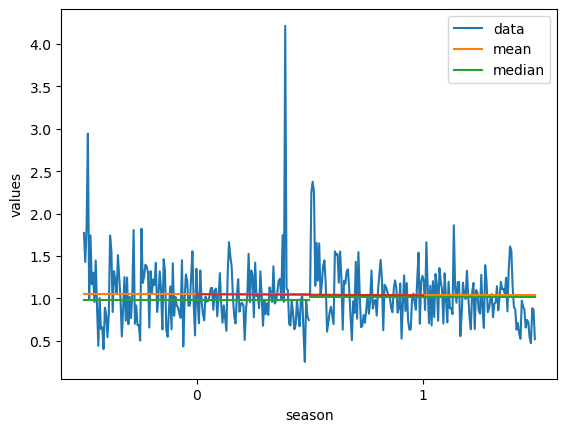

In [65]:
means = plot_seasons(detrended, 2)

In [66]:
# Multiplicative decomposition
def decomposition(data, order, plot=True):
    values = data.values

    trend = running_average(values, order)
    detrended = values[order:] / trend
    
    season = [detrended[i::order].mean() for i in range(order)]
    seasonality = np.array(season*(detrended.shape[0]//order+1))[:detrended.shape[0]]
    
    residuals = values[order:] / (trend*seasonality)

    if plot:
        fig, axs = plt.subplots(4, 1, figsize=(22, 16), sharex=True)
        index = data.index

        axs[0].plot(index, values)
        axs[0].set_title('Original data')
        
        axs[1].plot(index[order:], trend)
        axs[1].set_title('Trend')

        axs[2].plot(index[order:], detrended)
        axs[2].set_title('Seasonality')

        axs[3].plot(index[order:], residuals)
        axs[3].set_title('Residuals')
        
    return values, trend, seasonality, residuals

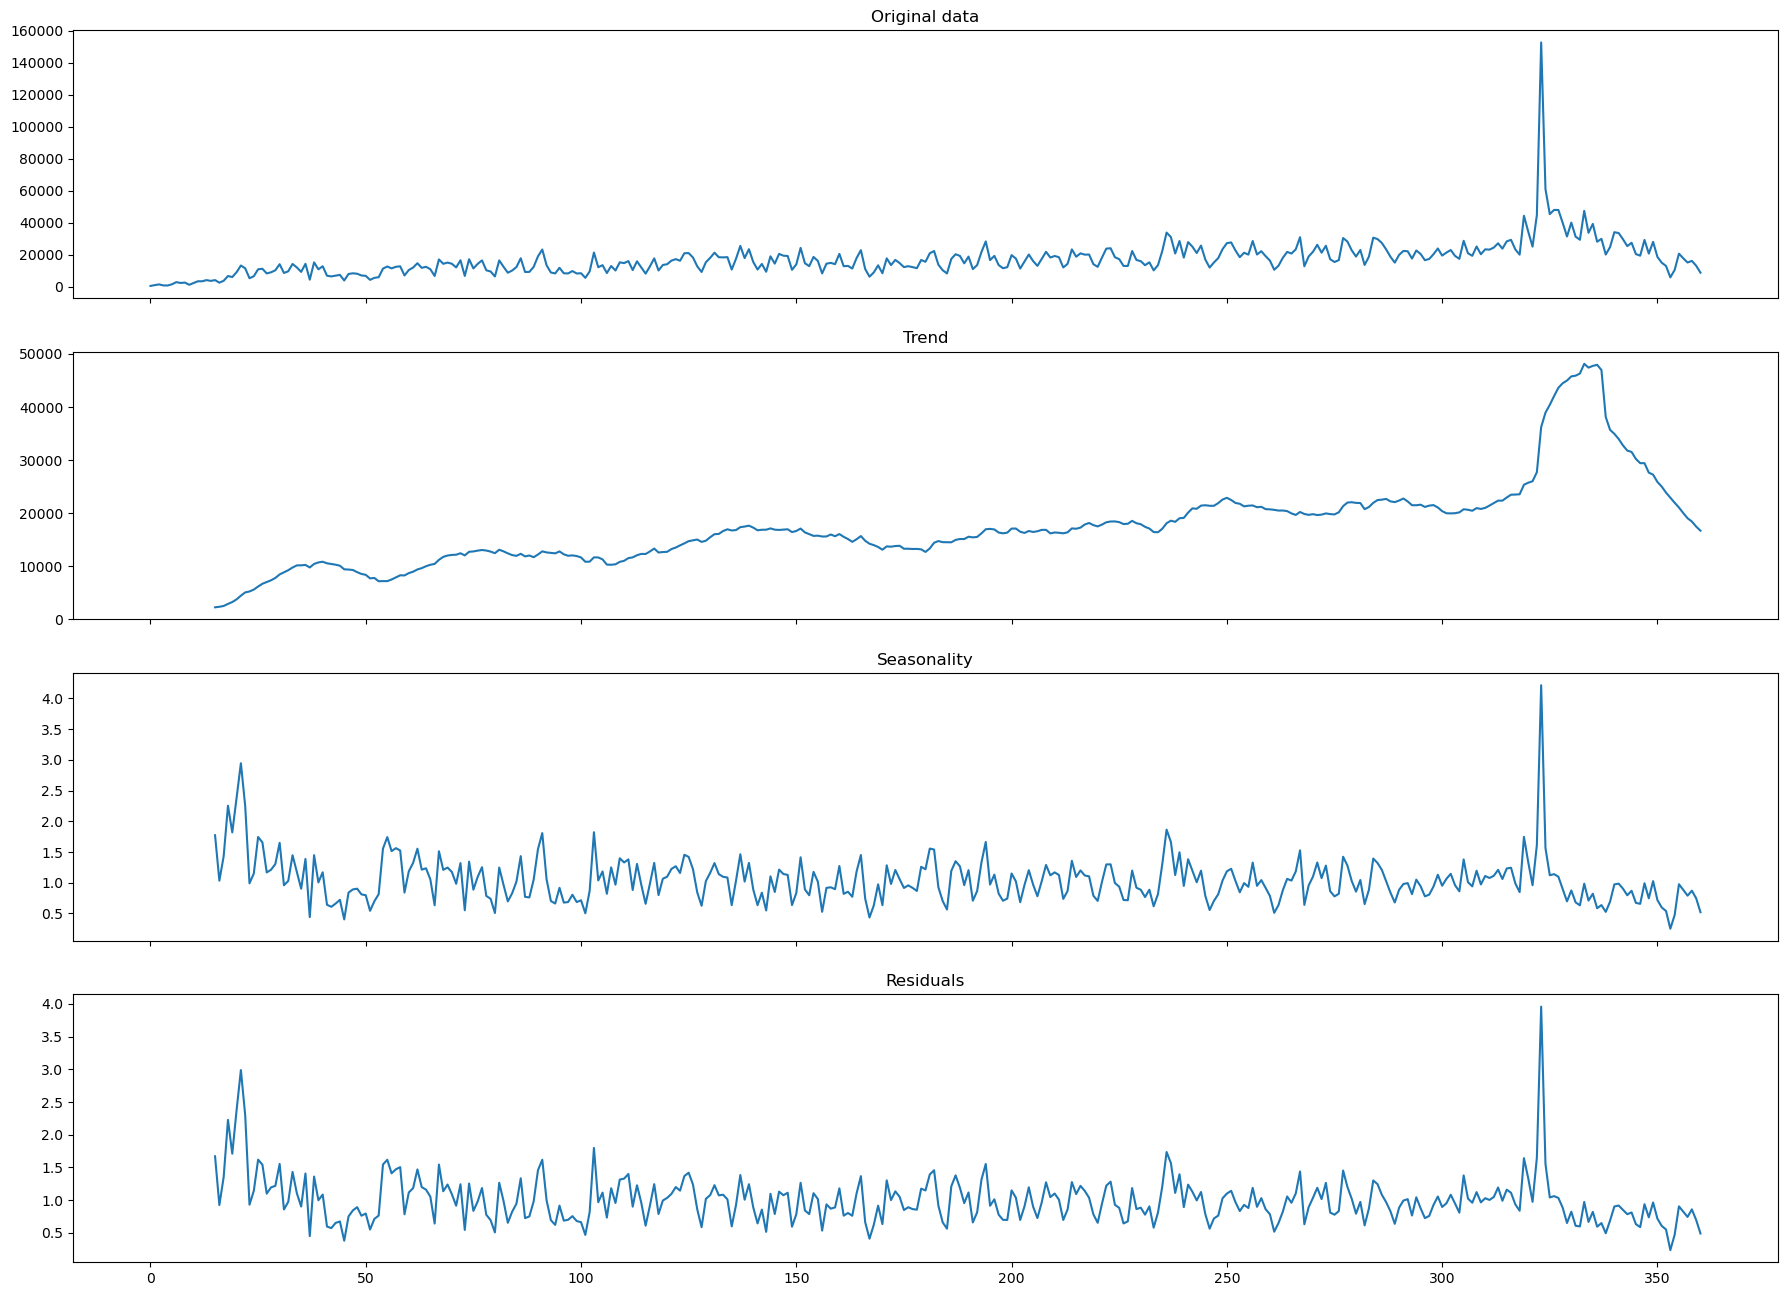

In [69]:
values, trend, seasonality, residuals = decomposition(df2['product_sales_amt'], 15)

#### Transformation

In [70]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=4).mean()
    rolstd = timeseries.rolling(window=4).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')  # Drop NA values which adfuller doesn't handle
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

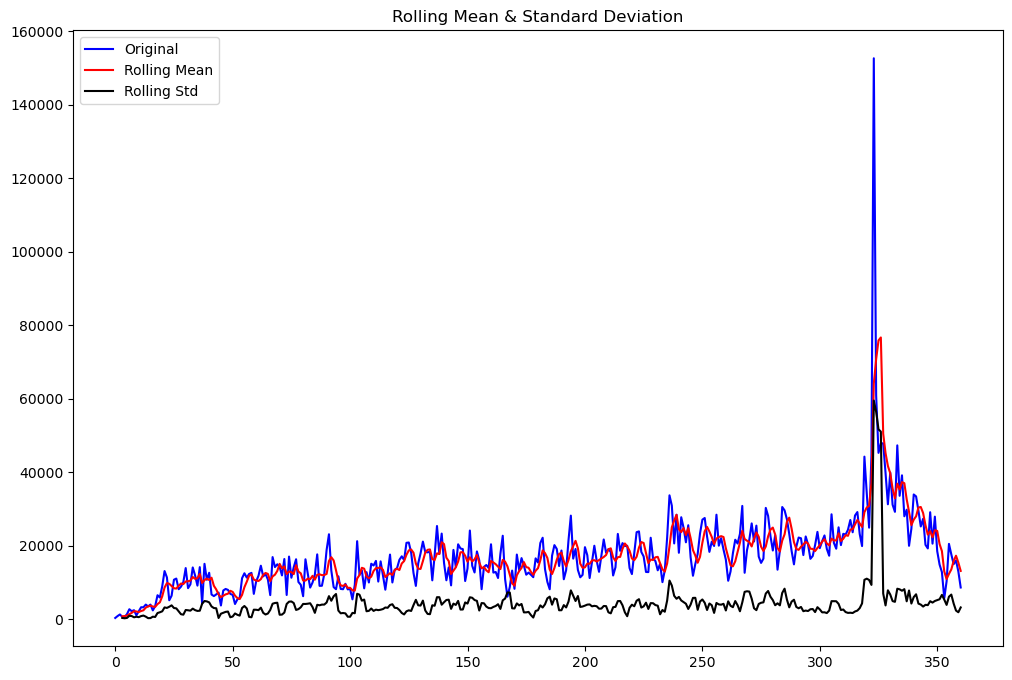

Results of Dickey-Fuller Test:
Test Statistic                  -3.024736
p-value                          0.032648
#Lags Used                       6.000000
Number of Observations Used    354.000000
Critical Value (1%)             -3.448958
Critical Value (5%)             -2.869739
Critical Value (10%)            -2.571138
dtype: float64


In [71]:
test_stationarity(df2['product_sales_amt'])

#### 1. first difference

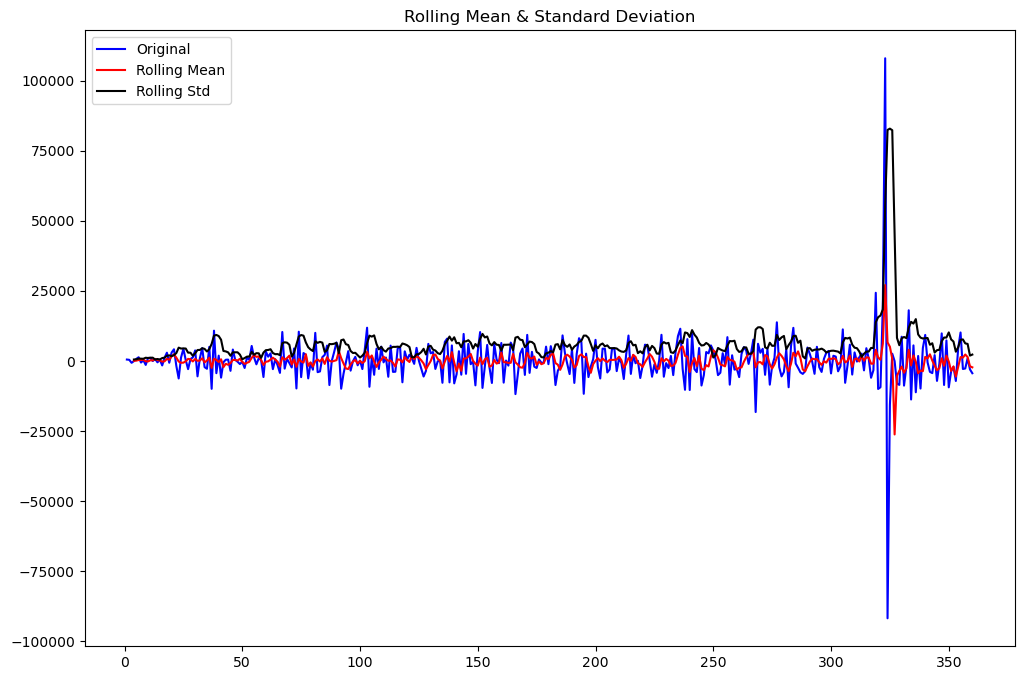

Results of Dickey-Fuller Test:
Test Statistic                -1.273552e+01
p-value                        9.179046e-24
#Lags Used                     5.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64


In [72]:
df2['first_difference'] = df2['product_sales_amt'] - df2['product_sales_amt'].shift(1)
test_stationarity(df2['first_difference'].dropna(inplace=False))

#### 2. Seasonal Difference

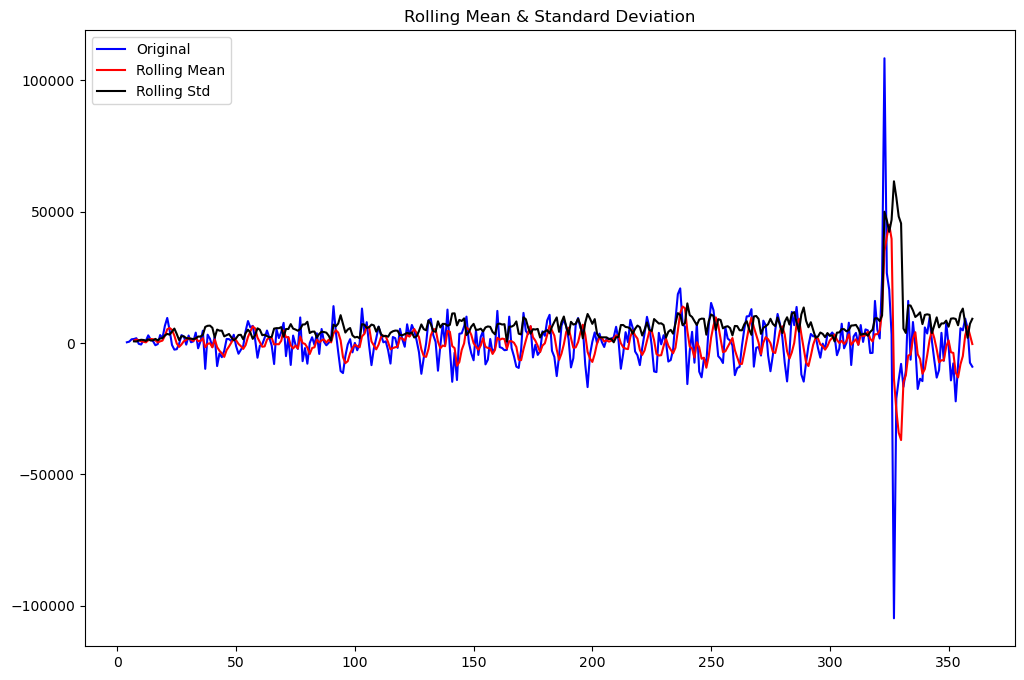

Results of Dickey-Fuller Test:
Test Statistic                -5.908364e+00
p-value                        2.675066e-07
#Lags Used                     1.500000e+01
Number of Observations Used    3.410000e+02
Critical Value (1%)           -3.449673e+00
Critical Value (5%)           -2.870053e+00
Critical Value (10%)          -2.571306e+00
dtype: float64


In [73]:
df2['seasonal_difference'] = df2['product_sales_amt'] - df2['product_sales_amt'].shift(4)
test_stationarity(df2['seasonal_difference'].dropna(inplace=False))

#### 3. Seasonal Adjustment

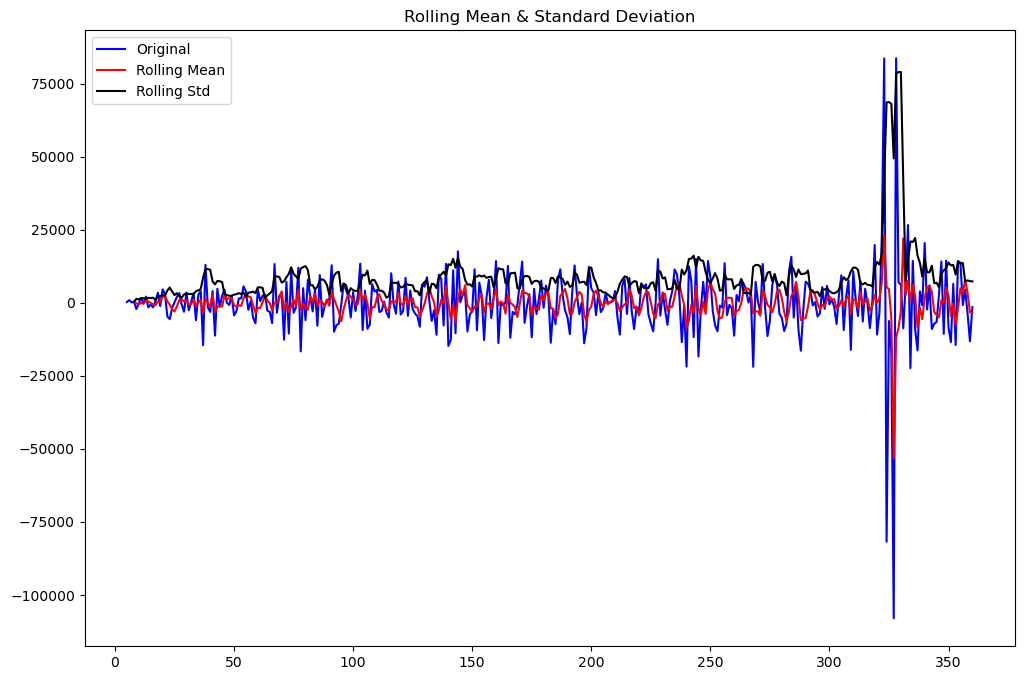

Results of Dickey-Fuller Test:
Test Statistic                -8.860192e+00
p-value                        1.490093e-14
#Lags Used                     1.600000e+01
Number of Observations Used    3.390000e+02
Critical Value (1%)           -3.449788e+00
Critical Value (5%)           -2.870104e+00
Critical Value (10%)          -2.571332e+00
dtype: float64


In [74]:
df2['seasonal_first_difference'] = df2['first_difference'] - df2['first_difference'].shift(4)
test_stationarity(df2['seasonal_first_difference'].dropna(inplace=False))

As you can see by the p-value, taking the seasonal first difference has now made our data stationary

## 3.4 Estimating an ARIMA Model

In [87]:
!pip install pmdarima

     -------------------------------------- 615.0/615.0 kB 1.4 MB/s eta 0:00:00


In [88]:
import pmdarima as pm

ts = df['product_sales_amt']
model = pm.auto_arima(ts, seasonal=True, m=12, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=178.04 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=627913.213, Time=1.43 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=627914.587, Time=8.93 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=627914.839, Time=9.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=643178.769, Time=0.47 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=627914.905, Time=7.49 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=627914.795, Time=5.77 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=627916.281, Time=69.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=627912.906, Time=1.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=627914.508, Time=7.65 sec


KeyboardInterrupt: 

In [104]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(df2['product_sales_amt'], trend='n', order=(1,0,0))
result = mod.fit()

In [105]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:      product_sales_amt   No. Observations:                  361
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3801.376
Date:                Wed, 13 Mar 2024   AIC                           7606.752
Time:                        18:11:24   BIC                           7614.530
Sample:                             0   HQIC                          7609.844
                                - 361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8944      0.006    139.703      0.000       0.882       0.907
sigma2      8.187e+07   1.28e-13   6.38e+20      0.000    8.19e+07    8.19e+07
Ljung-Box (L1) (Q):                  32.07   Jarque-

In [106]:
print(result.params)

ar.L1     8.943503e-01
sigma2    8.187138e+07
dtype: float64
